<a href="https://colab.research.google.com/github/C1587S/NN-AudioClassification/blob/master/Notebook_audioClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ========================
# importación y transformación de datos
# ========================
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pylab as pylab
import IPython.display as ipd
from pathlib import Path

# ========================
# neuronal networks
# ========================
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import ExponentialLR
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms


# ========================
# system
# ========================
import os
import copy
import time
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

class color:
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   CYAN = '\033[96m'
   END = '\033[0m'

# Transformación de datos

In [0]:
y,sr=librosa.load(file_to_open,duration=5)
sound,_=librosa.effects.trim(y)
librosa.display.waveplot(sound,sr=sr,alpha=0.5)

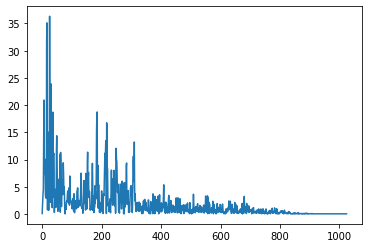

In [0]:
# aplicamos la transformada de fourier
n_fft=2048
D=np.abs(librosa.stft(sound[:n_fft],n_fft=n_fft,hop_length=n_fft+1))
plt.plot(D)

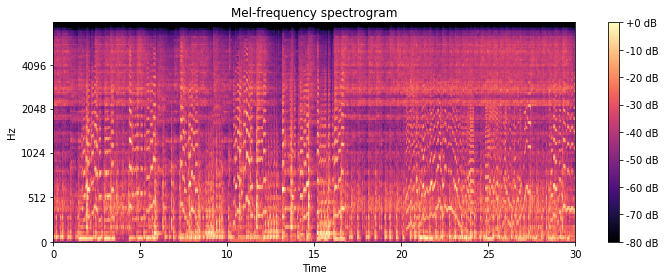

<Figure size 432x288 with 0 Axes>

In [0]:
S = librosa.feature.melspectrogram(y=y, sr=sr)

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()
g=""
plt.savefig('img.png')
plt.clf()

In [0]:
import IPython.display as ipd
ipd.Audio(file_to_open)

In [0]:
data_folder = Path("data/genres")
folder=Path("img_data/train_data")

    
genero=["blues",
       "classical",
       "country",
       "disco",
       "hiphop",
       "jazz",
       "metal",
       "pop",
       "reggae",
       "rock"]

file_type=".wav"


#recorre todos los datos
y=[]
sr=[]
for i in range(10):
    print(i)
    folder=Path("img_data/train_data")
    for j in range(100):
        
        #paths para recorrer carpetas
        if j<10:
            file_name= genero[i]+".0000"+str(j)+file_type
            file_to_open= data_folder / genero[i] / file_name
        else:
            file_name= genero[i]+".000"+str(j)+file_type
            file_to_open= data_folder / genero[i] / file_name
            
        #lee el archivo de audio
        y,sr=librosa.load(file_to_open, duration=30)
        
        #genera el espectograma
        S=librosa.feature.melspectrogram(y=y,
                                         sr=sr,
                                         n_fft=1024,
                                         hop_length=512)
        
        S_dB = librosa.power_to_db(S, ref=np.max)  #pasa a decibeles
        ST=np.transpose(S_dB)
    
        pylab.figure(figsize=(3,3))
        pylab.axis('off') 
        pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
        librosa.display.specshow(ST)#, cmap="gray")
        
        
        if j<10:
            file_name= genero[i]+".0000"+str(j)+".jpg"
            save= folder / genero[i] / file_name
        else:
            file_name= genero[i]+".000"+str(j)+".jpg"
            save= folder / genero[i] / file_name     
        
        if j==79:
            folder=Path("img_data/test_data")
        
        pylab.savefig(save, bbox_inches=None, pad_inches=0)
        pylab.close()
      

# Importación de datos

In [2]:
# Conectar a la nube (collab):
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Cambiar el directorio al local (collab):
cd drive/My Drive/AudioClassifier/NN-AudioClassification/

/content/drive/My Drive/AudioClassifier


In [18]:
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
input_size  = 3*216*216 # Dimension de datos de entrada (28 x 28)
num_classes = 10        # MNIST tiene 10 clases (numeros del 1 al 10)
num_epochs  = 15        # Numero de epocas para entrenar
bs          = 20        # Tamano de lote (batch_size)

In [0]:
traindir = "img_data/train_data"
testdir  = "img_data/test_data"
data_dir = "img_data"
# cargar datos para todos los batchsizes
train_loader, test_loader = load_dataset(traindir, testdir)

In [0]:
# para checar las dimensiones de la imagen
for i, (xi, yi) in enumerate(test_loader):
            print(xi.shape)
            print(yi.shape)

**Test para diferentes tamaños del batch**
- sin dropout en la red neuronal de 2 capas escondidas (200 y 60 unidades)

| batch-size | precision | perdida |
|------------|-----------|---------|
|     10     |     10%   |  2.31   |
|     15     |     31%   |  1.30   |
|   **20**   |   **32%** |**1.45** |
|     21     |     26%   |  1.19   |
|     25     |     30%   |  1.11   |
|     30     |     25%   |  1.13   |
|     50     |     19%   |  1.78   |

Dado lo anterior se fijóó el bs en 20.

Ahora bien, la precisión no se estandariza. Se aumenta el núúmero de épocas a 15.


Epoca: 1/10, Paso: 10/40, Perdida:11.25086
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 20/40, Perdida:2.65754
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 30/40, Perdida:4.62649
Precision del modelo en 200 canciones: 26.0 %
Epoca: 1/10, Paso: 40/40, Perdida:2.19070
Precision del modelo en 200 canciones: 24.0 %
Epoca: 2/10, Paso: 10/40, Perdida:2.33962
Precision del modelo en 200 canciones: 17.0 %
Epoca: 2/10, Paso: 20/40, Perdida:1.96917
Precision del modelo en 200 canciones: 28.0 %
Epoca: 2/10, Paso: 30/40, Perdida:2.10370
Precision del modelo en 200 canciones: 25.5 %
Epoca: 2/10, Paso: 40/40, Perdida:2.42548
Precision del modelo en 200 canciones: 10.5 %
Epoca: 3/10, Paso: 10/40, Perdida:1.98747
Precision del modelo en 200 canciones: 22.0 %
Epoca: 3/10, Paso: 20/40, Perdida:1.97048
Precision del modelo en 200 canciones: 19.5 %
Epoca: 3/10, Paso: 30/40, Perdida:2.72560
Precision del modelo en 200 canciones: 9.0 %
Epoca: 3/10, Paso: 40/40, Perdid

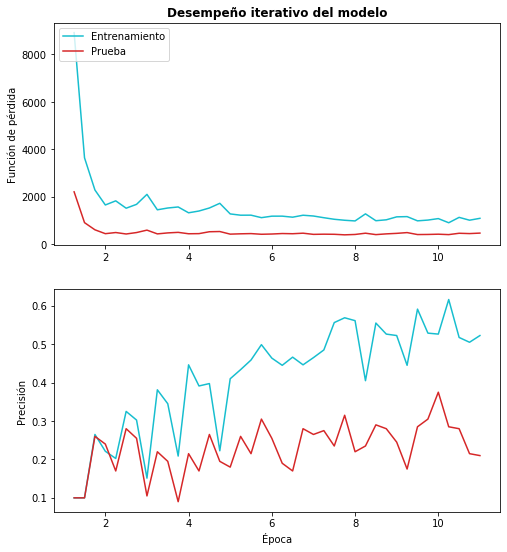

In [0]:
torch.manual_seed(123456789)
dropout_prob = 0.5 
input_size   = 3*216*216
num_epochs   = 5
num_classes  = 10
gamma        = 0.6 # ajsute exponencial
modelo_test  = RedNeuronal2_ReLu(input_size, num_classes).to(device)

entrenamiento_redesProf(model = modelo_test, 
                        input_size = 3*216*216, 
                        lr = 0.001, 
                        num_epochs = 10, 
                        num_classes = 10)

En el anterior ejercicio se definió el batch size de 20, y se observa que la precisióón tiende a estar entre el 30% y 40%.

Ahora se procede a entrenar varios modelos con redes profundas.

In [0]:
# Red neuronal de 1 capa escondida  (500 unidades) con activaciones ReLU
RN1_ReLu = RedNeuronal1_ReLu(input_size, num_classes).to(device)

# Red neuronal de 2 capas escondidas (200, 60 unidades)
RN2_ReLu = RedNeuronal2_ReLu(input_size, num_classes).to(device)

# Red neuronal de 3 capas escondidas (500, 100 y 30 unidades) 
RN3_ReLu = RedNeuronal3_ReLu(input_size, num_classes).to(device)

# Red neuronal de 5 capas escondidas (500, 300, 100, 50, 30 unidades)
RN5_ReLu = RedNeuronal5_ReLu(input_size, num_classes).to(device)

# lista de redes profundas
modelos_redesProfundas = [RN1_ReLu, RN2_ReLu, RN3_ReLu, RN5_ReLu]

Entrenamiento de las redes

Red neuronal de 1 capa escondida  (500 unidades) con activaciones ReLU
Epoca: 1/10, Paso: 10/40, Perdida:2.28625
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 20/40, Perdida:2.42022
Precision del modelo en 200 canciones: 13.0 %
Epoca: 1/10, Paso: 30/40, Perdida:2.42052
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 40/40, Perdida:2.35391
Precision del modelo en 200 canciones: 17.0 %
Epoca: 2/10, Paso: 10/40, Perdida:2.33805
Precision del modelo en 200 canciones: 10.0 %
Epoca: 2/10, Paso: 20/40, Perdida:2.31831
Precision del modelo en 200 canciones: 17.0 %
Epoca: 2/10, Paso: 30/40, Perdida:2.32302
Precision del modelo en 200 canciones: 10.0 %
Epoca: 2/10, Paso: 40/40, Perdida:2.41674
Precision del modelo en 200 canciones: 10.0 %
Epoca: 3/10, Paso: 10/40, Perdida:2.32429
Precision del modelo en 200 canciones: 10.0 %
Epoca: 3/10, Paso: 20/40, Perdida:2.30406
Precision del modelo en 200 canciones: 10.0 %
Epoca: 3/10, Paso: 30/40, Perdida:2.32786
Precisi

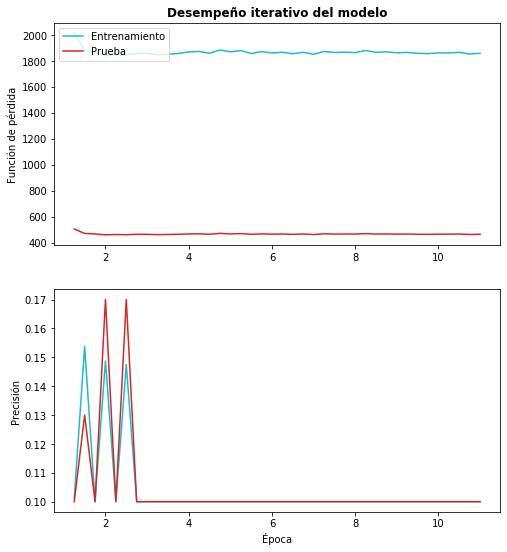

Red neuronal de 2 capas escondidas (200, 60 unidades)
Epoca: 1/10, Paso: 10/40, Perdida:5.84210
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 20/40, Perdida:3.42391
Precision del modelo en 200 canciones: 15.0 %
Epoca: 1/10, Paso: 30/40, Perdida:2.81973
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 40/40, Perdida:2.91913
Precision del modelo en 200 canciones: 22.0 %
Epoca: 2/10, Paso: 10/40, Perdida:2.20136
Precision del modelo en 200 canciones: 20.0 %
Epoca: 2/10, Paso: 20/40, Perdida:1.99838
Precision del modelo en 200 canciones: 24.0 %
Epoca: 2/10, Paso: 30/40, Perdida:1.70601
Precision del modelo en 200 canciones: 17.5 %
Epoca: 2/10, Paso: 40/40, Perdida:3.05537
Precision del modelo en 200 canciones: 16.5 %
Epoca: 3/10, Paso: 10/40, Perdida:1.50359
Precision del modelo en 200 canciones: 14.0 %
Epoca: 3/10, Paso: 20/40, Perdida:1.46883
Precision del modelo en 200 canciones: 14.0 %
Epoca: 3/10, Paso: 30/40, Perdida:1.59078
Precision del modelo en 

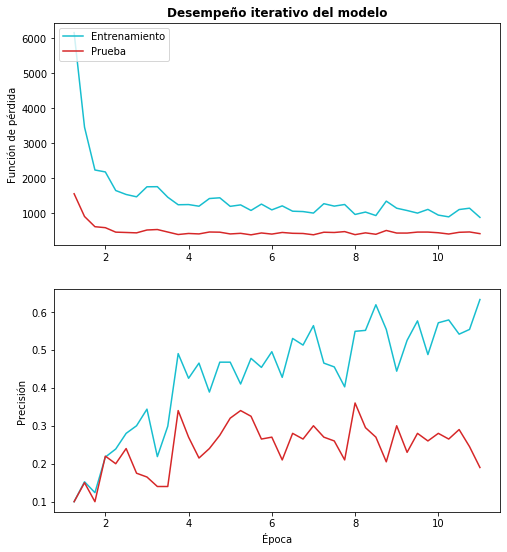

Red neuronal de 3 capas escondidas (500, 100 y 30 unidades) 
Epoca: 1/10, Paso: 10/40, Perdida:9.44795
Precision del modelo en 200 canciones: 12.0 %
Epoca: 1/10, Paso: 20/40, Perdida:2.56583
Precision del modelo en 200 canciones: 18.5 %
Epoca: 1/10, Paso: 30/40, Perdida:2.16763
Precision del modelo en 200 canciones: 23.5 %
Epoca: 1/10, Paso: 40/40, Perdida:2.20809
Precision del modelo en 200 canciones: 20.5 %
Epoca: 2/10, Paso: 10/40, Perdida:1.81778
Precision del modelo en 200 canciones: 17.5 %
Epoca: 2/10, Paso: 20/40, Perdida:1.99443
Precision del modelo en 200 canciones: 23.0 %
Epoca: 2/10, Paso: 30/40, Perdida:1.82394
Precision del modelo en 200 canciones: 31.0 %
Epoca: 2/10, Paso: 40/40, Perdida:2.19360
Precision del modelo en 200 canciones: 29.5 %
Epoca: 3/10, Paso: 10/40, Perdida:1.69352
Precision del modelo en 200 canciones: 20.0 %
Epoca: 3/10, Paso: 20/40, Perdida:2.21401
Precision del modelo en 200 canciones: 23.0 %
Epoca: 3/10, Paso: 30/40, Perdida:1.45648
Precision del mod

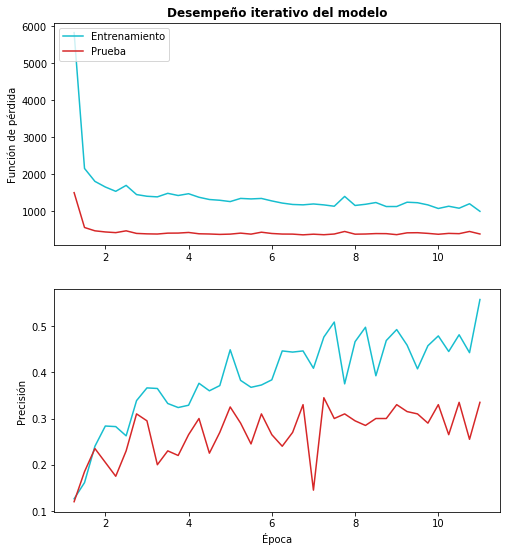

Red neuronal de 5 capas escondidas (500, 300, 100, 50, 30 unidades)
Epoca: 1/10, Paso: 10/40, Perdida:3.27239
Precision del modelo en 200 canciones: 10.0 %
Epoca: 1/10, Paso: 20/40, Perdida:2.43212
Precision del modelo en 200 canciones: 18.0 %
Epoca: 1/10, Paso: 30/40, Perdida:2.30839
Precision del modelo en 200 canciones: 15.0 %
Epoca: 1/10, Paso: 40/40, Perdida:2.27017
Precision del modelo en 200 canciones: 16.0 %
Epoca: 2/10, Paso: 10/40, Perdida:2.10580
Precision del modelo en 200 canciones: 20.0 %
Epoca: 2/10, Paso: 20/40, Perdida:1.99701
Precision del modelo en 200 canciones: 25.0 %
Epoca: 2/10, Paso: 30/40, Perdida:1.93958
Precision del modelo en 200 canciones: 25.5 %
Epoca: 2/10, Paso: 40/40, Perdida:2.14099
Precision del modelo en 200 canciones: 16.0 %
Epoca: 3/10, Paso: 10/40, Perdida:1.99795
Precision del modelo en 200 canciones: 14.5 %
Epoca: 3/10, Paso: 20/40, Perdida:2.05218
Precision del modelo en 200 canciones: 25.0 %
Epoca: 3/10, Paso: 30/40, Perdida:2.02103
Precision 

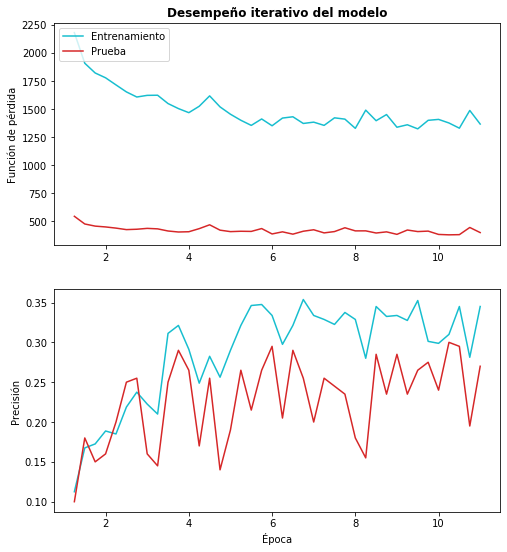

In [0]:
count = 0
for modelo_evaluado in modelos_redesProfundas:
    print("="*90) 
    if count == 0:
        print('Red neuronal de 1 capa escondida  (500 unidades) con activaciones ReLU')
        print("="*90) 
        count += 1           
    elif count == 1:
        print('Red neuronal de 2 capas escondidas (200, 60 unidades)')
        print("="*90) 
        count += 1        
    elif count == 2:
        print('Red neuronal de 3 capas escondidas (500, 100 y 30 unidades) ')
        print("="*90) 
        count += 1
    else:
        print('Red neuronal de 5 capas escondidas (500, 300, 100, 50, 30 unidades)')
        print("="*90) 
        count += 1

    # entrenamiento
    entrenamiento_redesProf(model= modelo_evaluado, 
                        input_size= 3*216*216, 
                        lr=0.001, 
                        num_epochs=10, 
                        num_classes=10)
    print("="*90) 

# Redes convolucionales

Utilizando modelos pre-entrenados de `torchvision`.

- Primero se deben estandarizar los datos
- Después se deben ajustar las dimensiones de las arquitecturas

In [0]:
# cargar datos (apendice)
train_loader_norm, val_loader_norm = load_normalized_dataset()

In [13]:
num_classes = 10
batch_size = 20
num_epochs = 15
feature_extract = True

from torchvision import models
# available models
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'Inception3',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'video',
 'wide_resnet101_2',
 'wide_resnet50_2']

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

A continuación se ajustan las siguientes arquitecturas:

- `alexnet`
- `resnet18`
- `vgg11_bn` (normalización de batches)
- `densenet121`

In [0]:
in_features = 3*224*224
feature_extract = True
use_pretrained = True
num_classes = 10

## alexnet
model_ft_alexnet = models.alexnet(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft_alexnet, feature_extract)
num_ftrs = model_ft_alexnet.classifier[6].in_features
model_ft_alexnet.classifier[6] = nn.Linear(num_ftrs,num_classes)
# print(model_ft_alexnet)

## resnet18
model_ft_resnet18 = models.resnet18(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft_resnet18, feature_extract)
num_ftrs = model_ft_resnet18.fc.in_features
model_ft_resnet18.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

## vgg11_bn
model_ft_vgg11bn = models.vgg11_bn(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft_vgg11bn, feature_extract)
num_ftrs = model_ft_vgg11bn.classifier[6].in_features
model_ft_vgg11bn.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

## densenet121
model_ft_densenet121 = models.densenet121(pretrained=use_pretrained)
set_parameter_requires_grad(model_ft_densenet121, feature_extract)
num_ftrs = model_ft_densenet121.classifier.in_features
model_ft_densenet121.classifier = nn.Linear(num_ftrs, num_classes)
input_size = 224


# lista de arquitecturas
modelos_cnn = [model_ft_alexnet, 
              model_ft_resnet18, 
              model_ft_vgg11bn, 
              model_ft_densenet121]

Epoca: 1/5, Paso: 10/40, Perdida:0.52239
Precision del modelo: 41.5 %
Epoca: 1/5, Paso: 20/40, Perdida:0.89265
Precision del modelo: 40.0 %
Epoca: 1/5, Paso: 30/40, Perdida:0.86193
Precision del modelo: 38.5 %
Epoca: 1/5, Paso: 40/40, Perdida:1.48016
Precision del modelo: 40.5 %
Epoca: 2/5, Paso: 10/40, Perdida:1.48346
Precision del modelo: 37.5 %
Epoca: 2/5, Paso: 20/40, Perdida:1.05569
Precision del modelo: 47.0 %
Epoca: 2/5, Paso: 30/40, Perdida:0.98205
Precision del modelo: 44.0 %
Epoca: 2/5, Paso: 40/40, Perdida:0.96937
Precision del modelo: 42.0 %
Epoca: 3/5, Paso: 10/40, Perdida:1.19824
Precision del modelo: 40.0 %
Epoca: 3/5, Paso: 20/40, Perdida:1.29716
Precision del modelo: 41.5 %
Epoca: 3/5, Paso: 30/40, Perdida:1.18115
Precision del modelo: 44.5 %
Epoca: 3/5, Paso: 40/40, Perdida:1.42753
Precision del modelo: 43.0 %
Epoca: 4/5, Paso: 10/40, Perdida:1.13424
Precision del modelo: 49.0 %
Epoca: 4/5, Paso: 20/40, Perdida:1.11970
Precision del modelo: 45.0 %
Epoca: 4/5, Paso: 30

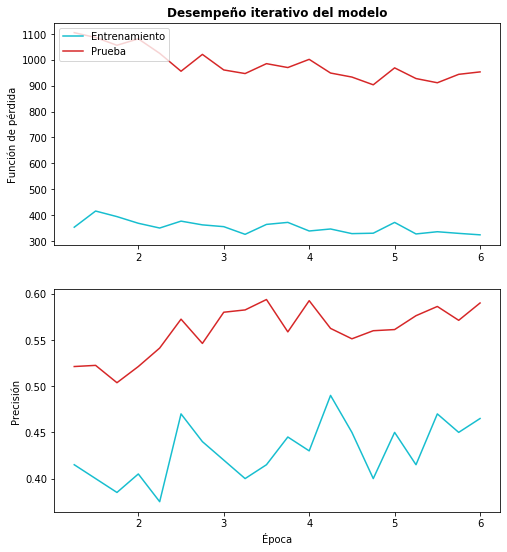

In [86]:
  modelo_evaluado = model_ft_alexnet
  modelo_ = modelo_evaluado.to(device)
  entrenamiento_cnn1(modelo_, lr=.001, gamma=0.6,
                       num_classes = 10, num_epochs=5)

Entrenamiento de las arquitecturas

In [80]:

print("device: ", device)
print("="*20)

count = 0
for modelo_evaluado in modelos_cnn:
  print("="*90) 
  if count == 0:
    print('Alexnet')
    print("="*90) 
    count += 1           
  elif count == 1:
    print('resnet18')
    print("="*90) 
    count += 1        
  elif count == 2:
    print('vgg11_bn')
    print("="*90) 
    count += 1
  else:
    print('densenet121')
    print("="*90) 
    count += 1

    # entrenamiento
  entrenamiento_cnn1(modelo_evaluado, lr=.001, gamma=0.6,
                       num_classes = 10, num_epochs=15)
    
print("Entrenamiento de los modelos terminado") 

device:  cuda
Alexnet
Epoca: 1/15, Paso: 10/40, Perdida:1.59414


RuntimeError: ignored

# Anexos

- Cargador de datos (formato inicial)

In [0]:
def load_dataset(traindir, testdir):
    bs = 20
    # train set
    data_path = Path(traindir)
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size  = bs,
        num_workers =  0,
        shuffle     = True
    )
    
    # test set
    data_path = Path(testdir)
    test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size  = bs,
        num_workers =  0,
        shuffle     = True
    )
    
    return train_loader , test_loader

- cargador de datos con normalización (pero no sigue el ejemplo de `torchvision`)

In [0]:
# nueva función

from torchvision import transforms 

def load_normalized_dataset(traindir = "img_data/train_data", 
                            valdir = "img_data/test_data"):
    input_size = 224 # para casi todas las arquitecturas es 224 (menos inception)
    batch_size = 20
    workers = 0
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # train loader
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(traindir, transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True)
    
    # validation loader
    val_loader = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True)
    
    
    return train_loader , val_loader

**Redes de capas profundas: modelos**

In [0]:
import torch.nn as nn    
# ==================
# Red neuronal de 1 capa (500 unidades) escondida con activaciones ReLU
# ==================    
class RedNeuronal1_ReLu(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RedNeuronal1_ReLu, self).__init__() 
        hidden_size = 500
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out


# ==================
# Red neuronal de 2 capas escondidas (200 y 60 unidades)
# con activaciones ReLU
# ==================
class RedNeuronal2_ReLu(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RedNeuronal2_ReLu, self).__init__() 
        
        self.drop_out = nn.Dropout()
        hidden_size1 = 200
        hidden_size2 = 60
        
        # 1ra capa escondida
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        # 2da capa escondida
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        # capa Output
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        
    def forward(self, x):
        
        # 1ra capa escondida
        out = self.fc1(x)
        out = self.relu(out)
        # out = self.drop_out(out) 
        # 2da capa escondida
        out = self.fc2(out)
        out = self.relu(out)
        # out = self.drop_out(out) 
        # capa Output
        out = self.fc3(out)

        return out

# ==================
# Red neuronal de 3 capas escondidas (500, 100 y 30 unidades) 
# con activaciones ReLu
# ==================

class RedNeuronal3_ReLu(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RedNeuronal3_ReLu, self).__init__() 
        
        hidden_size1 = 500
        hidden_size2 = 100
        hidden_size3 = 30  
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

# ==================
# Red neuronal de 5 capas escondidas (500, 300, 100, 50, 30 unidades)
# con activaciones ReLu
# ==================
class RedNeuronal5_ReLu(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RedNeuronal5_ReLu, self).__init__() 
        
        hidden_size1 = 500
        hidden_size2 = 300
        hidden_size3 = 100
        hidden_size4 = 50
        hidden_size5 = 30
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, hidden_size5) 
        self.fc6 = nn.Linear(hidden_size5, num_classes) 
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        return out


**Entrenamiento, perdida y gráficas para las redes profundas**

In [0]:
def precision(model, prueba=True):
    """
    Esta función calcula la precisión del modelo
    ARGS:
      * model: modelo definido en pytorch -
            model(input_size, num_classes).to(device)
      * Prueba = True: calcular la precisión sobre train_data
               = False: calcular la precisión sobre test_data
    """
    correct, total = (0,0)
    loader = test_loader if prueba else train_loader
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.reshape(-1, 3*216*216).to(device)
            yi = yi.to(device)
            output = model(xi)
            _, predicted = torch.max(output.data, 1)
            total += yi.size(0)
            correct += (predicted == yi).sum().item()

    if loader == test_loader:
      print(f'Precision del modelo en {total} canciones: {100 * correct / total} %')
    else: None

    return correct/total

def perdida(model, prueba=True):
    """
    Esta función evalúa la función de pérdida del modelo
    ARGS:
      * model: modelo definido en pytorch -
            model(input_size, num_classes).to(device)
      * Prueba = True: computar la f. de pérdida sobre train_data
                = False: computar la f. de pérdida sobre test_data
    """    
    trainset_loss = 0.0
    loader = test_loader if prueba else train_loader
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.reshape(-1, 3*216*216).to(device)
            yi = yi.to(device)
            output = model(xi)
            loss = loss_function(output, yi)
            batch_loss = loss.item() * yi.size(0)
            trainset_loss += batch_loss
    return trainset_loss
        
# Función para generar gráficas

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

    
def graficas(epocas,perd_train,perd_test,prec_train,prec_test):
    """
    Esta función grafica en dos subpáneles el desempeño del modelo
        - Panel 1,1: Función de pérdida en entrenamiento y prueba
        - Panel 1,2: Precisión en entrenamiento y prueba
    """
    
    plt.figure(figsize=(8,9))
    #fig.set_figheight(8)
    #fig.set_figwidth(9)
    # función de pérdida
    plt.subplot(2, 1, 1)
    plt.plot(epocas, perd_train, '-', color='tab:cyan', label = 'Entrenamiento')
    plt.plot(epocas, perd_test, '-', color='tab:red', label = 'Prueba')
    plt.title(f'Desempeño iterativo del modelo', fontweight="bold")
    plt.ylabel('Función de pérdida')
    plt.legend(loc='upper left')
    
    # precisión
    plt.subplot(2, 1, 2)
    plt.plot(epocas, prec_train, '-', color='tab:cyan')
    plt.plot(epocas, prec_test,'-' ,color='tab:red')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    #fig.tight_layout()
    plt.show()

def entrenamiento_redesProf(model, input_size= 3*216*216, lr=0.001, num_epochs=10, num_classes=10, gamma=0.6):
  #model = RedNeuronal2_ReLU(input_size, num_classes).to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler=ExponentialLR(optimizer, gamma, last_epoch=-1)

  # vectores de resultados  
  perd_train = []
  perd_test  = []
  prec_train = []
  prec_test  = []
  epocas = []
  i=0
  # ==================
  # Entrenamiento del modelo
  # ==================
  for epoch in range(num_epochs):
        for i, (xi, yi) in enumerate(train_loader):
            xi = xi.reshape(-1, 3*216*216).to(device) 
            yi = yi.to(device) 
            # Propagacion para adelante
            output = model(xi) 
            loss = loss_function(output, yi) 
            # Propagacion para atras y paso de optimizacion
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step() 

            if (i+1) % 10 == 0:
                print(color.END + 'Epoca: {}/{}, Paso: {}/{}, Perdida:{:.5f}'.format(epoch+1,
                       num_epochs, i+1, len(train_loader), loss.item()))

                # guarda datos por época        
                perd_train.append(perdida(model, prueba=False))
                perd_test.append(perdida(model, prueba=True))
                prec_train.append(precision(model, prueba=False))
                prec_test.append(precision(model, prueba=True))
                epocas.append(epoch+1+((i+1)/len(train_loader)))
    
    # gráfica por modelo
  print(color.BLUE + '='*30)
  print(color.BLUE + f'Tasa de aprendizaje: {lr}')
  graficas(epocas, perd_train, perd_test, prec_train, prec_test)
  print(color.BLUE + '='*30)

**Entrenamiento, perdida y gráficas para las redes convolucionales**

In [0]:
## funciones con esquema anterior (utiliza los datos sin normalizar)
# no estandariza los datos para usar torchvision

def precision1(model, prueba=True):
    """
    Esta función calcula la precisión del modelo
    ARGS:
      * model: modelo definido en pytorch -
            model(input_size, num_classes).to(device)
      * Prueba = True: calcular la precisión sobre train_data
               = False: calcular la precisión sobre test_data
    """
    correct, total = (0,0)
    loader = test_loader if prueba else train_loader
    with torch.no_grad():
        for xi, yi in loader:
            yi = yi.to(device)
            output = model(xi)
            _, predicted = torch.max(output.data, 1)
            total += yi.size(0)
            correct += (predicted == yi).sum().item()    
        
    return correct/total

def perdida1(model, prueba=True):
    """
    Esta función evalúa la función de pérdida del modelo
    ARGS:
      * model: modelo definido en pytorch -
            model(input_size, num_classes).to(device)
      * Prueba = True: computar la f. de pérdida sobre train_data
                = False: computar la f. de pérdida sobre test_data
    """    
    trainset_loss = 0.0
    loader = test_loader if prueba else train_loader
    with torch.no_grad():
        for xi, yi in loader:
            yi = yi.to(device)
            output = model(xi)
            loss = loss_function(output, yi)
            batch_loss = loss.item() * yi.size(0)
            trainset_loss += batch_loss
    return trainset_loss

# función para entrenar las arquitecturas de redes convolucionales

def entrenamiento_cnn(model, lr=.01, gamma=0.6, num_classes = 10):    
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define al ajustador de lr
    scheduler = ExponentialLR(optimizer, gamma, last_epoch=-1)

    torch.manual_seed(123456789)
    perd_train = []
    perd_test  = []
    prec_train = []
    prec_test  = []
    epocas  = []
    
# ==================
# Entrenamiento del modelo
# ==================
    for epoch in range(num_epochs):
        for i, (xi, yi) in enumerate(train_loader):
           # xi = xi.reshape(-1, 28*28).to(device) # imagenes y reshape se cargan a CPU - comentar
            yi = yi.to(device) # etiquetas  clasificación se carga a CPU
            # Propagacion para adelante
            output = model(xi) # prediccion del modelo
            loss = loss_function(output, yi) # evaluacion de la funcion de perdida
            # Propagacion para atras y paso de optimizacion
            optimizer.zero_grad() 
            loss.backward()
            # actualizar parámetros del modelo
            optimizer.step()
            
            if (i+1) % 10 == 0:
                print(color.END + 'Epoca: {}/{}, Paso: {}/{}, Perdida:{:.5f}'.format(epoch+1,
                       num_epochs, i+1, len(train_loader), loss.item()))
            
                # guarda datos por época        
                perd_train.append(perdida1(model, prueba=False))
                perd_test.append(perdida1(model, prueba=True))
                prec_train.append(precision1(model, prueba=False))
                prec_test.append(precision1(model, prueba=True))
                epocas.append(epoch+1+((i+1)/len(train_loader)))
                
         # se ajusta la magnitud de la lr exp. en cada época
        scheduler.step()
    
    # gráfica por modelo
    print(color.BLUE + '='*50)
    print(color.BLUE + f'Tasa de aprendizaje inicial: {lr}')
    graficas(epocas, perd_train, perd_test, prec_train, prec_test)
    print(color.BLUE + '='*50)

- Funciones para evaluar modelos precargados de `torchvision`

In [0]:
# funciones para entrenamiento de redes convolucionales precargadas en torchvision
# usando datos normalizados

def precision_1(model, prueba=True):
    """
    Esta función calcula la precisión del modelo
    ARGS:
      * model: modelo definido en pytorch -
            model(input_size, num_classes).to(device)
      * Prueba = True: calcular la precisión sobre train_data
               = False: calcular la precisión sobre test_data
    """
    correct, total = (0,0)
    loader = train_loader_norm if prueba else val_loader_norm
    with torch.no_grad():
        for xi, yi in loader:
            yi = yi.to(device)
            xi = xi.to(device)
            output = model(xi)
            _, predicted = torch.max(output.data, 1)
            total += yi.size(0)
            correct += (predicted == yi).sum().item()    
    
    if loader == val_loader_norm:
        print(f'Precision del modelo en validación: {100 * correct / total} %')
    else:
      print(f'Precision del modelo en entrenamiento: {100 * correct / total} %')
        
    return correct/total

def perdida_1(model, prueba=True):
    """
    Esta función evalúa la función de pérdida del modelo
    ARGS:
      * model: modelo definido en pytorch -
            model(input_size, num_classes).to(device)
      * Prueba = True: computar la f. de pérdida sobre train_data
                = False: computar la f. de pérdida sobre test_data
    """    
    loss_function = nn.CrossEntropyLoss()
    trainset_loss = 0.0
    loader = train_loader_norm if prueba else val_loader_norm
    with torch.no_grad():
        for xi, yi in loader:
            yi = yi.to(device)
            xi = xi.to(device)
            output = model(xi)
            loss = loss_function(output, yi)
            batch_loss = loss.item() * yi.size(0)
            trainset_loss += batch_loss
    return trainset_loss

def entrenamiento_cnn1(model, lr=.001, gamma=0.6, num_classes = 10, num_epochs=10):   
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define al ajustador de lr
    scheduler = ExponentialLR(optimizer, gamma, last_epoch=-1)

    torch.manual_seed(123456789)
    perd_train = []
    perd_test  = []
    prec_train = []
    prec_test  = []
    epocas  = []
    # ==================
    # Entrenamiento del modelo
    # ==================
    for epoch in range(num_epochs):
        for i, (xi, yi) in enumerate(train_loader_norm):
           # xi = xi.reshape(-1, 28*28).to(device) # imagenes y reshape se cargan a CPU - comentar
            xi = xi.to(device)
            yi = yi.to(device) # etiquetas  clasificación se carga a CPU
            # Propagacion para adelante
            output = model(xi) # prediccion del modelo
            loss = loss_function(output, yi) # evaluacion de la funcion de perdida
            # Propagacion para atras y paso de optimizacion
            optimizer.zero_grad() 
            loss.backward()
            # actualizar parámetros del modelo
            optimizer.step()
            
            if (i+1) % 10 == 0:
                print(color.END + 'Epoca: {}/{}, Paso: {}/{}, Perdida:{:.5f}'.format(epoch+1,
                       num_epochs, i+1, len(train_loader_norm), loss.item()))
            
                # guarda datos por época        
                perd_train.append(perdida_1(model, prueba=False))
                perd_test.append(perdida_1(model, prueba=True))
                prec_train.append(precision_1(model, prueba=False))
                prec_test.append(precision_1(model, prueba=True))
                epocas.append(epoch+1+((i+1)/len(train_loader_norm)))
                
         # se ajusta la magnitud de la lr exp. en cada época
        scheduler.step()
    
    # gráfica por modelo
    print(color.BLUE + '='*50)
    print(color.BLUE + f'Tasa de aprendizaje inicial: {lr}')
    graficas(epocas, perd_train, perd_test, prec_train, prec_test)
    print(color.BLUE + '='*50)

**Modelos de redes convolucionales propios**

In [0]:
import torch.nn.functional as F
dropout_prob = 0.5 

class RedConvolucional_test(nn.Module):
    def __init__(self, num_classes=10):
        super(RedConvolucional_test, self).__init__()
        # a) Capa convolucional con activaciones ReLU, tamaño de kernel 3, 
        # stride 1, y salida de 12 canales.
        self.drop_out = nn.Dropout()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, out_channels = 100, kernel_size=9), # , stride=1, padding=1
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(9,9)) # , stride=2
        # b) Capa densa con 200 unidades y activaciones ReLu
        self.layer4 = nn.Sequential(
            nn.Linear(52900, 10),
            nn.ReLU())
        # capa output : clasificación a 10 clases
        self.fc = nn.Linear(10, num_classes)  

    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)
        # capas densas
        out = self.layer4(out)
#        out = self.drop_out(out)       
        out = self.fc(out)
        return out

**`TorchVision` tutorial**

Pasos sugeridos en tutorial de `torchvision`
**Nota:** Aún hay problemas por solucionar en la etapa de implementación final

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
# función para ajustar modelos pre-cargados
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# ==============
# data loaders
# ==============
# Data augmentation and normalization for training
# Just normalization for validation
from torchvision import datasets, models, transforms
import os

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ==============
# optimizador
# ==============
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001) # para SGD , momentum=0.9

# ==============
# función de pérdida
# ==============
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


# ==============
# Train and evaluate
# ==============
model_ft, hist = train_model(model_ft, 
                             dataloaders_dict, 
                             criterion, 
                             optimizer_ft, 
                             num_epochs=num_epochs, 
                             is_inception=False)